<a href="https://colab.research.google.com/github/aziegert/Prediction_Of_Yield/blob/main/Prediction__Of_Yield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
#Basic
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Prerocessig
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
import optuna

In [ ]:
%matplotlib inline

#Loading data

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s3e14

  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 58.1MB/s]


In [ ]:
!unzip /content/playground-series-s3e14.zip

Archive:  /content/playground-series-s3e14.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
!kaggle datasets download -d shashwatwork/wild-blueberry-yield-prediction-dataset

  0% 0.00/23.9k [00:00<?, ?B/s]
100% 23.9k/23.9k [00:00<00:00, 49.3MB/s]


In [ ]:
!unzip /content/wild-blueberry-yield-prediction-dataset.zip

Archive:  /content/wild-blueberry-yield-prediction-dataset.zip
  inflating: WildBlueberryPollinationSimulationData.csv  


In [ ]:
df_org = pd.read_csv('/content/WildBlueberryPollinationSimulationData.csv')

#Data review

In [ ]:
df_train.sample(5)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
2301,2301,25.0,0.500,0.250,0.630,0.630,69.7,42.1,58.2,50.2,24.3,41.2,34.00,0.56,0.502842,0.433694,33.232449,5330.63134
4775,4775,12.5,0.250,0.250,0.630,0.500,94.6,57.2,79.0,68.2,33.0,55.9,1.00,0.10,0.570330,0.480779,39.675668,7241.37053
7404,7404,25.0,0.500,0.250,0.630,0.500,77.4,46.8,64.7,55.8,27.0,45.8,16.00,0.26,0.534252,0.473660,38.945152,6306.55062
1594,1594,12.5,0.250,0.250,0.250,0.380,69.7,42.1,58.2,50.2,24.3,41.2,34.00,0.56,0.384981,0.373856,29.085148,4112.89349
12891,12891,10.0,0.537,0.117,0.409,0.058,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.473689,0.428012,33.447471,5347.51393


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             10194 non-null  float64
 1   honeybee              10194 non-null  float64
 2   bumbles               10194 non-null  float64
 3   andrena               10194 non-null  float64
 4   osmia                 10194 non-null  float64
 5   MaxOfUpperTRange      10194 non-null  float64
 6   MinOfUpperTRange      10194 non-null  float64
 7   AverageOfUpperTRange  10194 non-null  float64
 8   MaxOfLowerTRange      10194 non-null  float64
 9   MinOfLowerTRange      10194 non-null  float64
 10  AverageOfLowerTRange  10194 non-null  float64
 11  RainingDays           10194 non-null  float64
 12  AverageRainingDays    10194 non-null  float64
 13  fruitset              10194 non-null  float64
 14  fruitmass             10194 non-null  float64
 15  seeds              

In [ ]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [ ]:
df_train.describe()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,15288.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


In [ ]:
df_test.describe()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
count,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000
mean,20385.500000,19.795958,0.391606,0.286307,0.491328,0.593222,82.207014,49.697204,68.687816,59.256465,28.674779,48.592643,18.507360,0.322501,0.501809,0.446345,36.136349
std,2942.898656,6.591864,0.390022,0.059867,0.148166,0.139897,9.153442,5.552286,7.647629,6.617055,3.198282,5.395790,11.780074,0.165342,0.074707,0.037054,4.019885
min,15289.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.233554,0.311921,24.320627
25%,17837.250000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.418867,33.231910
50%,20385.500000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506346,0.446570,36.013557
75%,22933.750000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.559325,0.472670,39.127263
max,25482.000000,37.500000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.139425


In [ ]:
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)
df_org = df_org.drop('Row#', axis=1)

In [ ]:
df_train_org = pd.concat([df_train, df_org]).reset_index()

In [ ]:
df_train['type'] = 'train'
df_test['type'] = 'test'
df_ = pd.concat([df_train, df_test])

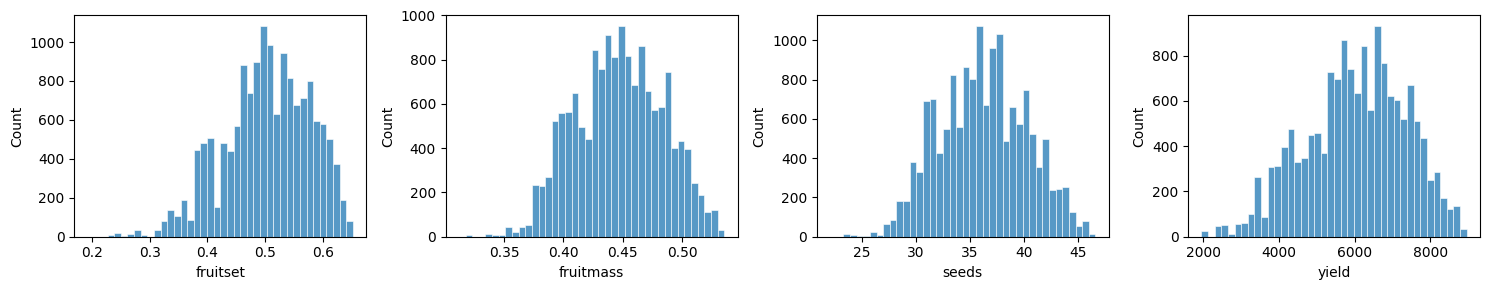

In [ ]:
df_hist = df_train.iloc[:,13:17]

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 3))
index = 0
axs = axs.flatten()
for k,v in df_hist.items():
    sns.histplot(data=df_hist, x=v, bins=40, edgecolor='white', ax=axs[index])
    index = index + 1

plt.tight_layout()

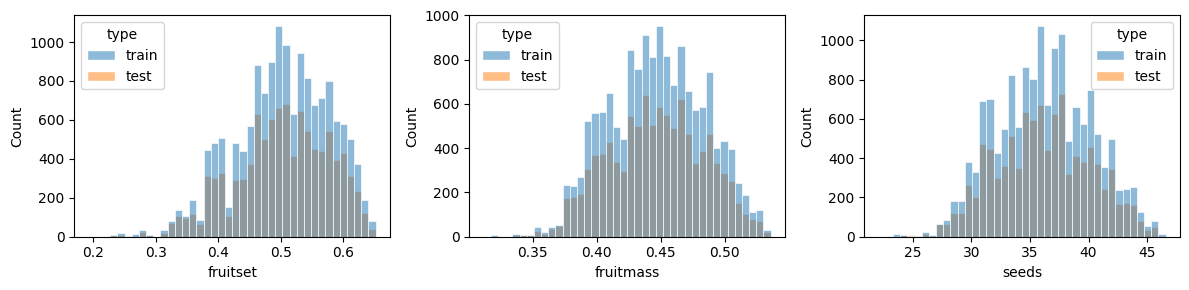

In [ ]:
df_hist_2 = df_.iloc[:,14:19]

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))
index = 0
axs = axs.flatten()
for k,v in df_hist_2.items():
    sns.histplot(data=df_hist_2, x=v, bins=40, hue='type', edgecolor='white', ax=axs[index])
    index = index + 1
    if index == 3:
      break

plt.tight_layout()

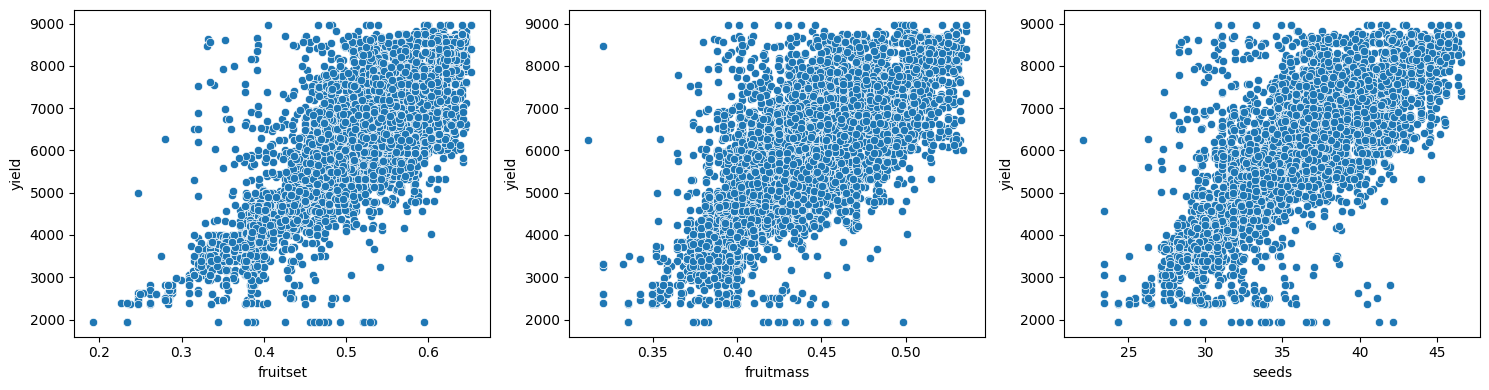

In [ ]:
df_scat = df_train.iloc[:,13:17]

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
index = 0
axs = axs.flatten()
for k,v in df_scat.items():
    sns.scatterplot(data=df_scat, x=v, y='yield', ax=axs[index])
    index+=1
    if index == 3:
      break

plt.tight_layout()

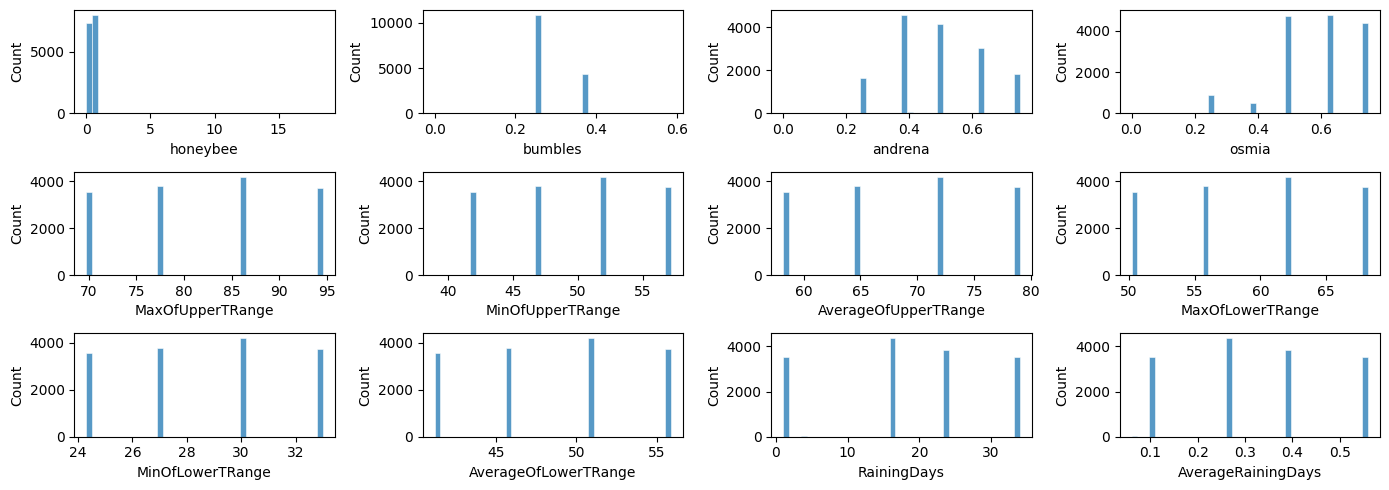

In [ ]:
df_hist_3 = df_train.iloc[:,1:13]

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(14, 5))
index = 0
axs = axs.flatten()
for k,v in df_hist_3.items():
    sns.histplot(data=df_hist_3, x=v, bins=40, edgecolor='white', ax=axs[index])
    index = index + 1

plt.tight_layout()

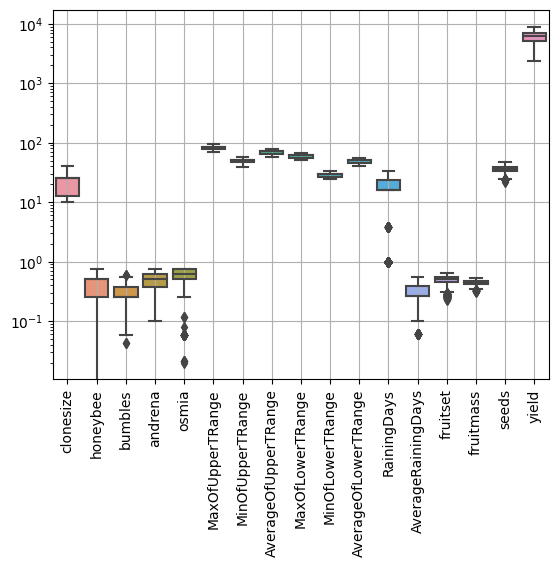

In [ ]:
ax = sns.boxplot(data=df_train, orient="v", showfliers=True)
ax.set_yscale("log")
plt.xticks(rotation = 90)
plt.grid(visible=True, which='major', axis='both')

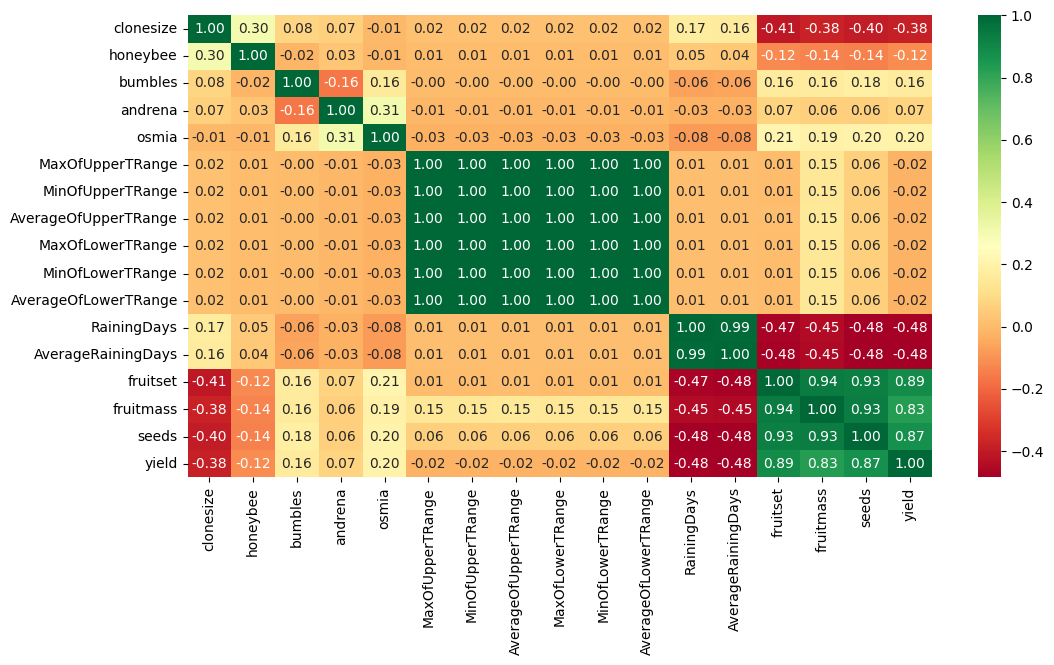

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.heatmap(df_train.iloc[:,:17].corr(), cmap='RdYlGn', annot=True, fmt='.2f')

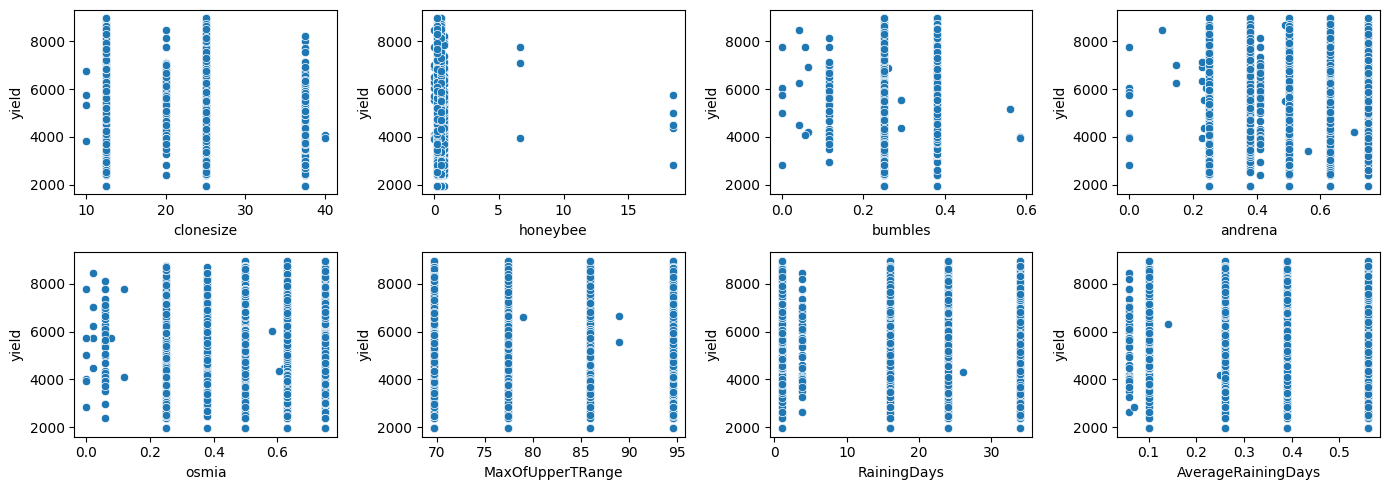

In [ ]:
df_scat_2 = df_train.iloc[:,[0,1,2,3,4,5,11,12,16]]

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(14, 5))
index = 0
axs = axs.flatten()
for k,v in df_scat_2.items():
    sns.scatterplot(data=df_scat_2, x=v, y='yield', ax=axs[index])
    index+=1
    if index == 8:
      break

plt.tight_layout()

#PreProcessig

##'yield' = 1945.53061

In [ ]:
df_y = df_train_org[df_train_org['yield'] < 2100].iloc[:,13:17]
df_y

,AverageRainingDays,fruitset,fruitmass,seeds
287,0.26,0.492810,0.424609,36.994030
327,0.26,0.594837,0.498479,42.171765
614,0.56,0.389453,0.382602,29.842285
1203,0.39,0.456503,0.426747,32.265346
1503,0.56,0.520181,0.463807,36.706592
2075,0.56,0.233554,0.335339,24.320627
3056,0.26,0.462102,0.435694,34.125467
4159,0.39,0.425493,0.427938,32.797666
4419,0.56,0.233554,0.335339,24.320627
4965,0.56,0.532228,0.445308,36.830820


In [ ]:
df_train = df_train.drop(df_train[df_train['yield'] < 2100].index)
df_train_org = df_train_org.drop(df_train_org[df_train_org['yield'] < 2100].index)

##duplicates

In [ ]:
duplicates = df_train.iloc[:,:17].duplicated().sum()
duplicates

7

In [ ]:
duplicates = df_train_org.iloc[:,:17].duplicated().sum()
duplicates

0

##outliers

In [ ]:
df_train_org[df_train_org['honeybee'] > 1]

,index,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
2263,2263,20.0,18.43,0.000,0.000,0.000,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.517994,0.364726,27.106391,5009.962220
5940,5940,20.0,18.43,0.293,0.234,0.058,77.4,46.8,64.7,55.8,27.0,45.3,34.00,0.56,0.372184,0.372179,29.702301,4356.945870
6818,6818,20.0,6.64,0.380,0.500,0.750,77.4,46.8,64.7,55.8,27.0,45.8,1.00,0.10,0.572046,0.476836,40.545823,7080.040040
11803,11803,20.0,18.43,0.042,0.630,0.021,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.424394,0.399935,31.881847,4480.070000
11948,11948,20.0,18.43,0.000,0.000,0.000,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.559628,0.364937,27.106391,5741.210300
13132,13132,20.0,6.64,0.250,0.229,0.500,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.360996,0.398475,31.081547,3937.915390
13493,13493,20.0,18.43,0.000,0.000,0.000,77.4,46.8,64.7,55.8,27.0,45.8,24.00,0.07,0.284443,0.355876,26.487322,2825.003740
15246,15246,20.0,6.64,0.000,0.000,0.000,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.551954,0.364937,28.284095,7778.349160
16050,761,20.0,6.64,0.000,0.000,0.000,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.508675,0.336240,24.601741,4936.364770
16051,762,20.0,18.43,0.000,0.000,0.000,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.559628,0.364937,27.106391,6131.309380


In [ ]:
df_train = df_train.drop(df_train[df_train['honeybee'] > 1].index)
df_train_org = df_train_org.drop(df_train_org[df_train_org['honeybee'] > 1].index)

#Model selection

In [ ]:
cols_all = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']

In [ ]:
X = df_train_org[cols_all]
y = df_train_org['yield']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'LightGBM Regressor': LGBMRegressor(),
    'CatBoost Regressor': CatBoostRegressor(verbose=False)
    }

# Model overview and MAE calculation for each model
mae_scores = {}
mae_val = {}

for name, model in tqdm(models.items()):

  if name in ['Linear Regression', 'K-Nearest Neighbors Regressor']:
    model = Pipeline([
        ('preprocessing', StandardScaler()),
         ('model', model)
         ])

  score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
  mae_scores[name] = -score.mean()

  model.fit(X_train, y_train)
  y_val_pred = model.predict(X_val)
  mae_val[name] = mean_absolute_error(y_val, y_val_pred)


train_results = pd.DataFrame(list(mae_scores.items()), columns=['model', 'MAE'])
val_results = pd.DataFrame(list(mae_val.items()), columns=['model', 'MAE_val'])
results = pd.merge(train_results, val_results, on='model')
results = results.sort_values(by='MAE_val')

results

100%|██████████| 6/6 [02:43<00:00, 27.31s/it]


,model,MAE,MAE_val
5,CatBoost Regressor,343.576051,339.004718
4,LightGBM Regressor,342.611032,339.988802
2,Random Forest Regressor,352.357030,349.951877
3,XGBoost Regressor,356.755090,354.961338
0,Linear Regression,361.044579,356.148027
1,K-Nearest Neighbors Regressor,438.066607,431.961807


#Feature selection

##Recursive feature elimination

###LightGBM

In [ ]:
rfe_GBM = RFECV(estimator=LGBMRegressor(), cv=10, scoring='neg_mean_absolute_error')
rfe_GBM.fit(X, y)

RFECV(cv=10, estimator=LGBMRegressor(), scoring='neg_mean_absolute_error')

In [ ]:
rfe_GBM = list(X.columns[rfe_GBM.support_])
rfe_GBM

['clonesize',
 'bumbles',
 'andrena',
 'osmia',
 'MaxOfUpperTRange',
 'RainingDays',
 'fruitset',
 'fruitmass',
 'seeds']

###CatBoost

In [ ]:
model_CB = CatBoostRegressor(verbose=False)

In [ ]:
rfe_CB = RFECV(estimator=model_CB, cv=5, scoring='neg_mean_absolute_error')
rfe_CB.fit(X, y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7f4bf4ea0e20>,
      scoring='neg_mean_absolute_error')

In [ ]:
rfe_CB = list(X.columns[rfe_CB.support_])
rfe_CB

['clonesize',
 'honeybee',
 'bumbles',
 'andrena',
 'osmia',
 'MaxOfUpperTRange',
 'MinOfUpperTRange',
 'AverageOfUpperTRange',
 'MaxOfLowerTRange',
 'MinOfLowerTRange',
 'AverageOfLowerTRange',
 'RainingDays',
 'AverageRainingDays',
 'fruitset',
 'fruitmass',
 'seeds']

In [ ]:
rfe_CB.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

##Mutual information

In [ ]:
mif_importances = mutual_info_regression(X, y, random_state=6)

mif_df = pd.concat([pd.DataFrame(X.columns, columns=['feat']),
                    pd.DataFrame(mif_importances, columns=['importance'])
                   ], axis=1).sort_values(by='importance', ascending=False)

mif_df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,feat,importance
13,fruitset,1.468885
15,seeds,1.255172
14,fruitmass,1.077144
12,AverageRainingDays,0.172300
11,RainingDays,0.162838
0,clonesize,0.102623
1,honeybee,0.080665
4,osmia,0.046757
2,bumbles,0.028090
3,andrena,0.026289


In [ ]:
fig = px.bar(mif_df.sort_values(by='importance'), x='importance', y='feat',
             height=500, width=700,
             title='Feature importances for Mutual info Regression metod')

fig.show()

#Models

In [ ]:
def get_result(model, X_train, X_val, y_train, y_val):

  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  MAE_train = round(mean_absolute_error(y_train, y_train_pred),4)

  y_val_pred = model.predict(X_val)
  MAE_val = round(mean_absolute_error(y_val, y_val_pred),4)

  results = pd.DataFrame({'TRAIN': [MAE_train], 'VAL': [MAE_val]})

  return results

In [ ]:
mif_11 = ['fruitset', 'seeds',	'fruitmass', 'AverageRainingDays', 'RainingDays',
          'clonesize',	'honeybee',	'osmia',	'bumbles', 'andrena', 'MaxOfLowerTRange']

mif_10 = ['fruitset', 'seeds',	'fruitmass', 'AverageRainingDays',
          'clonesize',	'honeybee',	'osmia',	'bumbles', 'andrena', 'MaxOfLowerTRange']

mif_7 = ['fruitset', 'seeds',	'fruitmass', 'AverageRainingDays', 'RainingDays',
          'clonesize',	'honeybee']

mif_6 = ['fruitset', 'seeds',	'fruitmass', 'AverageRainingDays', 'clonesize',	'honeybee']

mif_5 = ['fruitset', 'seeds',	'fruitmass', 'AverageRainingDays', 'RainingDays']

mif_4 = ['fruitset', 'seeds',	'fruitmass', 'AverageRainingDays']

mif_3 = ['fruitset', 'seeds',	'fruitmass']

In [ ]:
def choose_features(model):

    n_features = {'all_features': cols_all,
                  'mif_11': mif_11,
                  'mif_10': mif_10,
                  'mif_7': mif_7,
                  'mif_6': mif_6,
                  'mif_5': mif_5,
                  'mif_4': mif_4,
                  'mif_3': mif_3,
                  'rfe_GBM_features': rfe_GBM}

    mae_scores = {}
    mae_val = {}

    for name, features in tqdm(n_features.items()):

      score = cross_val_score(model, X_train[features], y_train, cv=10, scoring='neg_mean_absolute_error')
      mae_scores[name] = -score.mean()

      model.fit(X_train[features], y_train)
      y_val_pred = model.predict(X_val[features])
      mae_val[name] = mean_absolute_error(y_val, y_val_pred)


    train_results = pd.DataFrame(list(mae_scores.items()), columns=['n_features', 'MAE'])
    val_results = pd.DataFrame(list(mae_val.items()), columns=['n_features', 'MAE_val'])
    results = pd.merge(train_results, val_results, on='n_features')
    results = results.sort_values(by='MAE_val')

    return results

##LightGBMRegressor

In [ ]:
results_GBM = choose_features(LGBMRegressor())
results_GBM

100%|██████████| 9/9 [00:18<00:00,  2.04s/it]


,n_features,MAE,MAE_val
2,mif_10,341.644108,339.239039
8,rfe_GBM_features,342.036508,339.532855
1,mif_11,341.215115,339.591527
0,all_features,342.611032,339.988802
4,mif_6,342.616354,341.435290
3,mif_7,344.214081,341.680677
5,mif_5,344.625824,342.507215
6,mif_4,344.362562,342.921013
7,mif_3,345.387756,343.808438


###mif_10

In [ ]:
X = X_train[mif_10]
y = y_train

In [ ]:
def objective_GBM_10(trial):
    params = {'metric': 'mae',
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 6,
        'verbose': -1}

    optuna_model = LGBMRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_GBM_10 = optuna.create_study(direction='minimize', sampler=sampler)
study_GBM_10.optimize(objective_GBM_10, n_trials=200, show_progress_bar=True)

[I 2023-05-27 19:45:56,409] A new study created in memory with name: no-name-23f0657b-57d1-4687-aea6-2c9400f67fbb
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-05-27 19:45:58,795] Trial 0 finished with value: 386.5020396790797 and parameters: {'max_depth': 11, 'n_estimators': 365, 'learning_rate': 0.2465475077942917, 'num_leaves': 40, 'min_child_samples': 15, 'colsample_bytree': 0.7975260321031201, 'subsample': 0.7649086810964107}. Best is trial 0 with value: 386.5020396790797.
[I 2023-05-27 19:46:03,519] Trial 1 finished with value: 361.8620796758062 and parameters: {'max_depth': 7, 'n_estimators': 368, 'learning_rate': 0.18713331022663096, 'num_leaves': 236, 'min_child_samples': 75, 'colsample_bytree': 0.7590182059996344, 'subsample': 0.7894293001130785}. Best is trial 1 with value: 361.8620796758062.
[I 2023-05-27 19:46:09,061] Trial 2 finished with value: 396.2649224625867 and parameters: {'max_depth': 9, 'n_estimators': 991, 'learning_rate': 0.24613760087963055, 'num_leaves': 223, 'min_child_samples': 89, 'colsample_bytree': 0.9118797162852607, 'subsample': 0.5272372539111774}. Best is trial 1 with value: 361.8620796758062.
[I 20

In [ ]:
params_GBM_10 = study_GBM_10.best_params
model_GBM_10 = LGBMRegressor(**params_GBM_10, random_state=6)
metrics_GBM_10 = get_result(model_GBM_10, X, X_val[mif_10], y_train, y_val)
metrics_GBM_10

,TRAIN,VAL
0,316.5196,335.7699


###rfe_GBM

In [ ]:
X = X_train[rfe_GBM]
y = y_train

In [ ]:
def objective_GBM_rfe(trial):
    params = {'metric': 'mae',
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 6,
        'verbose': -1}

    optuna_model = LGBMRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_GBM_rfe = optuna.create_study(direction='minimize', sampler=sampler)
study_GBM_rfe.optimize(objective_GBM_rfe, n_trials=200, show_progress_bar=True)

[I 2023-05-27 20:46:01,608] A new study created in memory with name: no-name-5d1bad7f-a365-4492-8545-d0b775f390c0
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-05-27 20:46:02,817] Trial 0 finished with value: 373.2720330812142 and parameters: {'max_depth': 11, 'n_estimators': 199, 'learning_rate': 0.2465475077942917, 'num_leaves': 40, 'min_child_samples': 15, 'colsample_bytree': 0.7975260321031201, 'subsample': 0.7649086810964107}. Best is trial 0 with value: 373.2720330812142.
[I 2023-05-27 20:46:04,885] Trial 1 finished with value: 353.09224473202187 and parameters: {'max_depth': 7, 'n_estimators': 201, 'learning_rate': 0.18713331022663096, 'num_leaves': 236, 'min_child_samples': 75, 'colsample_bytree': 0.7590182059996344, 'subsample': 0.7894293001130785}. Best is trial 1 with value: 353.09224473202187.
[I 2023-05-27 20:46:11,124] Trial 2 finished with value: 377.65379756405594 and parameters: {'max_depth': 9, 'n_estimators': 496, 'learning_rate': 0.24613760087963055, 'num_leaves': 223, 'min_child_samples': 89, 'colsample_bytree': 0.9118797162852607, 'subsample': 0.5272372539111774}. Best is trial 1 with value: 353.09224473202187.
[

In [ ]:
params_GBM_rfe = study_GBM_rfe.best_params
model_GBM_rfe = LGBMRegressor(**params_GBM_rfe, random_state=6)
metrics_GBM_rfe = get_result(model_GBM_rfe, X, X_val[rfe_GBM], y_train, y_val)
metrics_GBM_rfe

,TRAIN,VAL
0,316.7303,336.0316


###mif_11

In [ ]:
X = X_train[mif_11]
y = y_train

In [ ]:
def objective_GBM_11(trial):
    params = {'metric': 'mae',
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 6,
        'verbose': -1}

    optuna_model = LGBMRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_GBM_11 = optuna.create_study(direction='minimize', sampler=sampler)
study_GBM_11.optimize(objective_GBM_11, n_trials=200, show_progress_bar=True)

[I 2023-05-27 20:53:55,854] A new study created in memory with name: no-name-652b2141-0c05-4007-b4cb-0920e5f48a99
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-05-27 20:53:57,123] Trial 0 finished with value: 371.71185349689114 and parameters: {'max_depth': 11, 'n_estimators': 199, 'learning_rate': 0.2465475077942917, 'num_leaves': 40, 'min_child_samples': 15, 'colsample_bytree': 0.7975260321031201, 'subsample': 0.7649086810964107}. Best is trial 0 with value: 371.71185349689114.
[I 2023-05-27 20:53:58,138] Trial 1 finished with value: 355.5983558666911 and parameters: {'max_depth': 7, 'n_estimators': 201, 'learning_rate': 0.18713331022663096, 'num_leaves': 236, 'min_child_samples': 75, 'colsample_bytree': 0.7590182059996344, 'subsample': 0.7894293001130785}. Best is trial 1 with value: 355.5983558666911.
[I 2023-05-27 20:54:00,944] Trial 2 finished with value: 379.4123680182058 and parameters: {'max_depth': 9, 'n_estimators': 496, 'learning_rate': 0.24613760087963055, 'num_leaves': 223, 'min_child_samples': 89, 'colsample_bytree': 0.9118797162852607, 'subsample': 0.5272372539111774}. Best is trial 1 with value: 355.5983558666911.
[I 

In [ ]:
params_GBM_11 = study_GBM_11.best_params
model_GBM_11 = LGBMRegressor(**params_GBM_11, random_state=6)
metrics_GBM_11 = get_result(model_GBM_11, X, X_val[mif_11], y_train, y_val)
metrics_GBM_11

,TRAIN,VAL
0,321.1779,337.2


###all features

In [ ]:
X = X_train[cols_all]
y = y_train

In [ ]:
def objective_GBM(trial):
    params = {'metric': 'mae',
        'max_depth': trial.suggest_int("max_depth", 2, 15),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 6,
        'verbose': -1}

    optuna_model = LGBMRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_GBM_all = optuna.create_study(direction='minimize', sampler=sampler)
study_GBM_all.optimize(objective_GBM, n_trials=500, show_progress_bar=True)

[I 2023-05-27 18:27:27,033] A new study created in memory with name: no-name-2e8a75a3-25a3-43a6-8f16-4be7c96500a2
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-05-27 18:27:29,116] Trial 0 finished with value: 377.6606366759846 and parameters: {'max_depth': 14, 'n_estimators': 365, 'learning_rate': 0.2465475077942917, 'num_leaves': 25, 'min_child_samples': 15, 'colsample_bytree': 0.7975260321031201, 'subsample': 0.7649086810964107}. Best is trial 0 with value: 377.6606366759846.
[I 2023-05-27 18:27:31,096] Trial 1 finished with value: 362.3250359616156 and parameters: {'max_depth': 7, 'n_estimators': 368, 'learning_rate': 0.18713331022663096, 'num_leaves': 227, 'min_child_samples': 75, 'colsample_bytree': 0.7590182059996344, 'subsample': 0.7894293001130785}. Best is trial 1 with value: 362.3250359616156.
[I 2023-05-27 18:27:41,613] Trial 2 finished with value: 402.75191092090716 and parameters: {'max_depth': 11, 'n_estimators': 991, 'learning_rate': 0.24613760087963055, 'num_leaves': 214, 'min_child_samples': 89, 'colsample_bytree': 0.9118797162852607, 'subsample': 0.5272372539111774}. Best is trial 1 with value: 362.3250359616156.
[I 

In [ ]:
params_GBM_all = study_GBM_all.best_params
model_GBM_all = LGBMRegressor(**params_GBM_all, random_state=6)
metrics_GBM_all = get_result(model_GBM_all, X, X_val[cols_all], y_train, y_val)
metrics_GBM_all

,TRAIN,VAL
0,321.4478,336.4694


In [ ]:
optuna.visualization.plot_optimization_history(study_GBM_all)

##CatBoostRegressor

In [ ]:
results_CB = choose_features(CatBoostRegressor(verbose=False))
results_CB

100%|██████████| 9/9 [04:58<00:00, 33.14s/it]


,n_features,MAE,MAE_val
1,mif_11,343.940967,338.105713
2,mif_10,343.702671,338.463354
8,rfe_GBM_features,343.575595,338.539460
0,all_features,343.576051,339.004718
4,mif_6,344.030002,340.298118
3,mif_7,344.091617,340.957627
6,mif_4,344.580509,341.918575
5,mif_5,344.368500,342.127924
7,mif_3,345.412907,343.324602


###mif_11

In [ ]:
X = X_train[mif_11]
y = y_train

In [ ]:
def objective_CB_11(trial):
    params = {'eval_metric': 'MAE',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False}

    optuna_model = CatBoostRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB_11 = optuna.create_study(direction='minimize', sampler=sampler)
study_CB_11.optimize(objective_CB_11, n_trials=100, show_progress_bar=True)

[I 2023-05-27 21:18:04,249] A new study created in memory with name: no-name-92ff3a5c-de3e-49d6-bdc1-4fd7ff9e5007
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-27 21:18:11,616] Trial 0 finished with value: 366.5187131503203 and parameters: {'n_estimators': 452, 'max_depth': 6, 'learning_rate': 0.2465475077942917, 'l2_leaf_reg': 0.5127965946799741, 'bagging_temperature': 0.10765667993596795, 'border_count': 165}. Best is trial 0 with value: 366.5187131503203.
[I 2023-05-27 21:18:15,865] Trial 1 finished with value: 342.7830763319447 and parameters: {'n_estimators': 288, 'max_depth': 7, 'learning_rate': 0.10128694693272544, 'l2_leaf_reg': 6.262942378741292, 'bagging_temperature': 0.4381414261088741, 'border_count': 196}. Best is trial 1 with value: 342.7830763319447.
[I 2023-05-27 21:18:23,184] Trial 2 finished with value: 350.1226005035379 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.19396117367278254, 'l2_leaf_reg': 9.903220286596822, 'bagging_temperature': 0.8198581969218414, 'border_count': 124}. Best is trial 1 with value: 342.7830763319447.
[I 2023-05-27 21:19:13,252] Trial 3 finished with value: 347

In [ ]:
params_CB_11 = study_CB_11.best_params
model_CB_11 = CatBoostRegressor(**params_CB_11, random_state=6, verbose=False)
metrics_CB_11 = get_result(model_CB_11, X, X_val[mif_11], y_train, y_val)
metrics_CB_11

,TRAIN,VAL
0,328.9636,338.2001


###mif_10

In [ ]:
X = X_train[mif_10]
y = y_train

In [ ]:
def objective_CB_10(trial):
    params = {'eval_metric': 'MAE',
        'n_estimators': trial.suggest_int('n_estimators', 200, 700),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False}

    optuna_model = CatBoostRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB_10 = optuna.create_study(direction='minimize', sampler=sampler)
study_CB_10.optimize(objective_CB_10, n_trials=100, show_progress_bar=True)

[I 2023-05-27 22:13:44,077] A new study created in memory with name: no-name-2ecfcd40-3c32-4eef-9a3e-92a6b69f8ad6
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-27 22:13:50,035] Trial 0 finished with value: 357.3969771491295 and parameters: {'n_estimators': 647, 'max_depth': 4, 'learning_rate': 0.2465475077942917, 'l2_leaf_reg': 0.5127965946799741, 'bagging_temperature': 0.10765667993596795, 'border_count': 165}. Best is trial 0 with value: 357.3969771491295.
[I 2023-05-27 22:13:53,872] Trial 1 finished with value: 343.4182421121283 and parameters: {'n_estimators': 465, 'max_depth': 4, 'learning_rate': 0.10128694693272544, 'l2_leaf_reg': 6.262942378741292, 'bagging_temperature': 0.4381414261088741, 'border_count': 196}. Best is trial 1 with value: 343.4182421121283.
[I 2023-05-27 22:14:01,110] Trial 2 finished with value: 349.45819741743014 and parameters: {'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.19396117367278254, 'l2_leaf_reg': 9.903220286596822, 'bagging_temperature': 0.8198581969218414, 'border_count': 124}. Best is trial 1 with value: 343.4182421121283.
[I 2023-05-27 22:14:12,935] Trial 3 finished with value: 34

In [ ]:
params_CB_10 = study_CB_10.best_params
model_CB_10 = CatBoostRegressor(**params_CB_10, random_state=6, verbose=False)
metrics_CB_10 = get_result(model_CB_10, X, X_val[mif_10], y_train, y_val)
metrics_CB_10

,TRAIN,VAL
0,314.3255,336.171


###rfe_GBM

In [ ]:
X = X_train[rfe_GBM]
y = y_train

In [ ]:
def objective_CB_rfe(trial):
    params = {'eval_metric': 'MAE',
        'n_estimators': trial.suggest_int('n_estimators', 200, 700),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False}

    optuna_model = CatBoostRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB_rfe = optuna.create_study(direction='minimize', sampler=sampler)
study_CB_rfe.optimize(objective_CB_rfe, n_trials=100, show_progress_bar=True)

[I 2023-05-27 23:04:17,412] A new study created in memory with name: no-name-cba29c76-c455-4c49-853d-145018169366
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-27 23:04:25,275] Trial 0 finished with value: 358.5645209236351 and parameters: {'n_estimators': 647, 'max_depth': 4, 'learning_rate': 0.2465475077942917, 'l2_leaf_reg': 0.5127965946799741, 'bagging_temperature': 0.10765667993596795, 'border_count': 165}. Best is trial 0 with value: 358.5645209236351.
[I 2023-05-27 23:04:29,349] Trial 1 finished with value: 343.9046194118747 and parameters: {'n_estimators': 465, 'max_depth': 4, 'learning_rate': 0.10128694693272544, 'l2_leaf_reg': 6.262942378741292, 'bagging_temperature': 0.4381414261088741, 'border_count': 196}. Best is trial 1 with value: 343.9046194118747.
[I 2023-05-27 23:04:34,213] Trial 2 finished with value: 349.45170937709884 and parameters: {'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.19396117367278254, 'l2_leaf_reg': 9.903220286596822, 'bagging_temperature': 0.8198581969218414, 'border_count': 124}. Best is trial 1 with value: 343.9046194118747.
[I 2023-05-27 23:04:46,090] Trial 3 finished with value: 34

In [ ]:
params_CB_rfe = study_CB_rfe.best_params
model_CB_rfe = CatBoostRegressor(**params_CB_rfe, random_state=6, verbose=False)
metrics_CB_rfe = get_result(model_CB_rfe, X, X_val[rfe_GBM], y_train, y_val)
metrics_CB_rfe

,TRAIN,VAL
0,315.423,337.9324


###all features

In [ ]:
X = X_train[cols_all]
y = y_train

In [ ]:
def objective_CB_all(trial):
    params = {'eval_metric': 'MAE',
        'n_estimators': trial.suggest_int('n_estimators', 200, 700),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False}

    optuna_model = CatBoostRegressor(**params)
    cvs = cross_val_score(optuna_model, cv=5, X=X, y=y,
                          scoring='neg_mean_absolute_error')
    score = -cvs.mean()
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB_all = optuna.create_study(direction='minimize', sampler=sampler)
study_CB_all.optimize(objective_CB_all, n_trials=100, show_progress_bar=True)

[I 2023-05-27 22:40:58,972] A new study created in memory with name: no-name-dc7a97d7-5ac6-44a7-a770-590969fcba9c
/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-27 22:41:07,532] Trial 0 finished with value: 359.44346449860467 and parameters: {'n_estimators': 647, 'max_depth': 4, 'learning_rate': 0.2465475077942917, 'l2_leaf_reg': 0.5127965946799741, 'bagging_temperature': 0.10765667993596795, 'border_count': 165}. Best is trial 0 with value: 359.44346449860467.
[I 2023-05-27 22:41:11,712] Trial 1 finished with value: 343.52512802234514 and parameters: {'n_estimators': 465, 'max_depth': 4, 'learning_rate': 0.10128694693272544, 'l2_leaf_reg': 6.262942378741292, 'bagging_temperature': 0.4381414261088741, 'border_count': 196}. Best is trial 1 with value: 343.52512802234514.
[I 2023-05-27 22:41:19,021] Trial 2 finished with value: 348.46961205504533 and parameters: {'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.19396117367278254, 'l2_leaf_reg': 9.903220286596822, 'bagging_temperature': 0.8198581969218414, 'border_count': 124}. Best is trial 1 with value: 343.52512802234514.
[I 2023-05-27 22:41:30,051] Trial 3 finished with valu

In [ ]:
params_CB_all = study_CB_all.best_params
model_CB_all = CatBoostRegressor(**params_CB_all, random_state=6, verbose=False)
metrics_CB_all = get_result(model_CB_all, X, X_val[cols_all], y_train, y_val)
metrics_CB_all

,TRAIN,VAL
0,319.284,337.2652


#Summary of results

In [ ]:
#Summary for LGBMRegressor
result_GBM = pd.concat([metrics_GBM_10, metrics_GBM_rfe, metrics_GBM_11, metrics_GBM_all], keys=['mif_10', 'rfe_GBM', 'mif_11', 'all'])
result_GBM

,,TRAIN,VAL
mif_10,0,316.5196,335.7699
rfe_GBM,0,316.7303,336.0316
mif_11,0,321.1779,337.2000
all,0,321.4478,336.4694


In [ ]:
#Summary for CatBoostRegressor
result_CB = pd.concat([metrics_CB_10, metrics_CB_rfe, metrics_CB_11, metrics_CB_all], keys=['mif_10', 'rfe_GBM', 'mif_11', 'all'])
result_CB

,,TRAIN,VAL
mif_10,0,314.3255,336.1710
rfe_GBM,0,315.4230,337.9324
mif_11,0,328.9636,338.2001
all,0,319.2840,337.2652


#Prediction and submission

In [ ]:
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
X_test = df_test[mif_10]
X_test.sample(5)

,fruitset,seeds,fruitmass,AverageRainingDays,clonesize,honeybee,osmia,bumbles,andrena,MaxOfLowerTRange
1482,0.478469,34.260034,0.421840,0.39,25.0,0.50,0.63,0.38,0.38,50.2
6910,0.444254,33.449385,0.423013,0.56,12.5,0.25,0.50,0.25,0.38,62.0
4214,0.538704,37.782288,0.446451,0.39,25.0,0.50,0.63,0.38,0.38,50.2
9747,0.603525,42.485953,0.506002,0.26,12.5,0.25,0.63,0.25,0.63,62.0
5368,0.586304,40.265408,0.483356,0.39,12.5,0.25,0.25,0.25,0.25,68.2


In [ ]:
best_model = model_GBM_10

In [ ]:
X = X_train[mif_10]
y = y_train

In [ ]:
best_model.fit(X, y)

LGBMRegressor(colsample_bytree=0.8031824234491852,
              learning_rate=0.037154612713091395, max_depth=5,
              min_child_samples=8, n_estimators=176, num_leaves=350,
              random_state=6, subsample=0.9194623359512195)

In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_pred

array([4258.47455328, 6117.18063082, 7198.74628155, ..., 6563.4095475 ,
       4412.12569836, 7267.19727398])

In [ ]:
df_submission['yield'] = y_test_pred
df_submission

,id,yield
0,15289,4258.474553
1,15290,6117.180631
2,15291,7198.746282
3,15292,4733.076457
4,15293,4119.651115
...,...,...
10189,25478,5473.570924
10190,25479,5761.648926
10191,25480,6563.409547
10192,25481,4412.125698


In [ ]:
df_submission.to_csv('submission_GBM_10.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
